### This is to make an extended figure that shows that temperature along the 1000m isobath 
#### or where the mCDW is


In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
import matplotlib.colors as mcolors
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36849,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:43993,Total threads: 4
Dashboard: /proxy/38653/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:43315,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### LOAD WIND TO CALCULATE WIND SPEED STREAMLINES

In [4]:
# load winds
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -200) 

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [5]:
# calculate the mean for the whole cycle
u=tau_x_con.mean('time')
v=tau_y_con.mean('time')

In [6]:
# calculate wind speed and load again 
wind_speed = np.sqrt(u**2 + v**2)

In [7]:
latitude = wind_speed.yu_ocean
longitude = wind_speed.xu_ocean

In [8]:
# wrap lons to avoid whte line
up, lon = add_cyclic_point(u, coord = longitude)
vp, lon = add_cyclic_point(v, coord = longitude)
ws, lon = add_cyclic_point(wind_speed, coord = longitude)

In [9]:
#lon

In [10]:
#this needs to be created for us to have a equally spaced vector for latitude. 
#to be part of the meshgrid on the streamlined plot. 
y = np.linspace(-75.5,-60, 357)

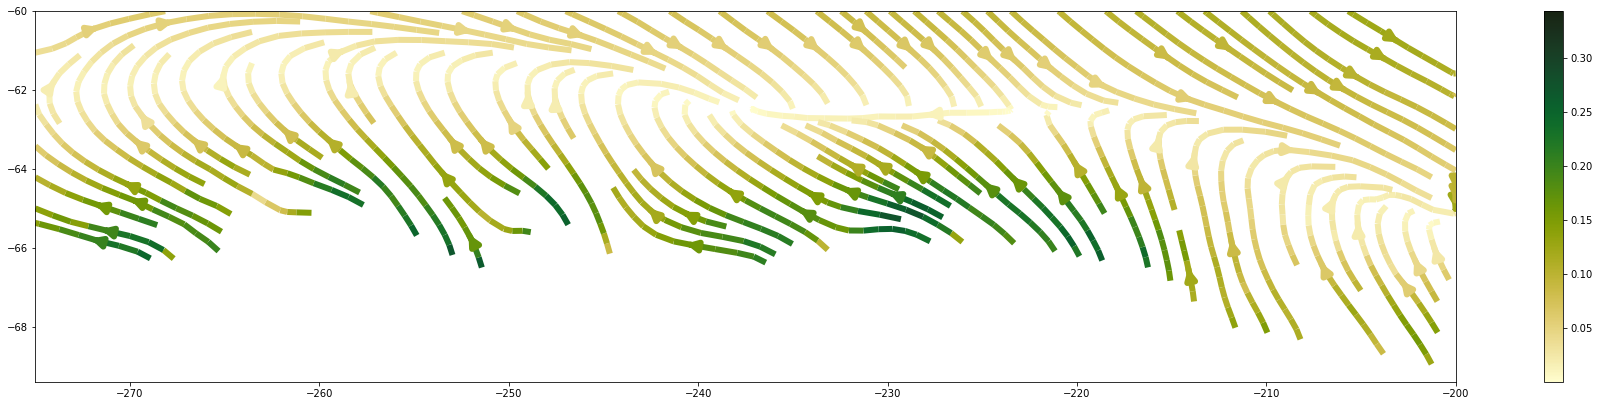

In [11]:
fig=plt.figure(figsize=(70, 15))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)   

# Original wind field
c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.speed, linewidth=6)
cbar2 = fig.colorbar(c.lines, orientation = 'vertical')

### Load temperature data at determined depth

In [12]:
# load temperature data at 400m:
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -200) 

depth_slice = 400
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -200)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

In [13]:
#average for temperature 
temp_400m_avg = temp_400m.mean('time')

In [14]:
# load temperature data at 400m:

depth_slice = 1000
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
#lon_slice  = slice(-275, -200)

temp_1000m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_1000m = temp_1000m.sel(yt_ocean=lat_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_1000m = temp_1000m.load()

In [15]:
#average for temperature 
temp_1000m_avg = temp_1000m.mean('time')

## Cut onshore mask 

In [16]:
# cut the data BOX 1
#lon_slice  = slice(-275,-200)
lat_slice  = slice(-75.5,-60)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

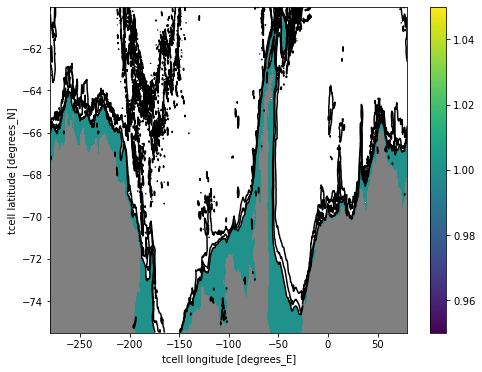

In [17]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [18]:
#apply the mask
temp_400m_off = temp_400m_avg*region_mask
temp_400m_off = temp_400m_off.where(temp_400m_off!=0)

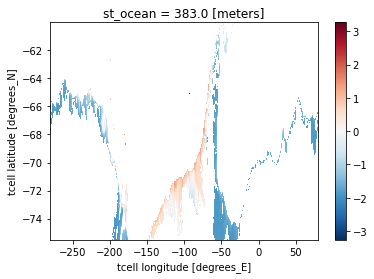

In [19]:
# first time step only:
temp_400m_off.plot()

## Cut offshore mask 

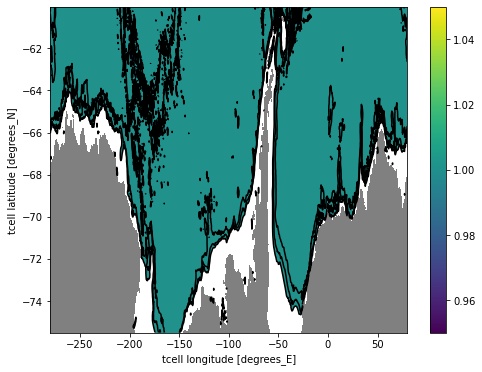

In [20]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice)#.sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [21]:
#apply the mask
temp_1000m_off = temp_1000m_avg*region_mask
temp_1000m_off = temp_1000m_off.where(temp_1000m_off!=0)

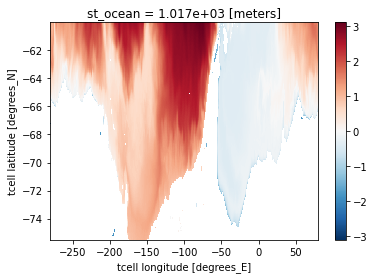

In [22]:
# first time step only:
temp_1000m_off.plot()

[Text(-280.0, 0, '80'),
 Text(-260.0, 0, '90'),
 Text(-240.0, 0, '100'),
 Text(-220.0, 0, '110'),
 Text(-200.0, 0, '120')]

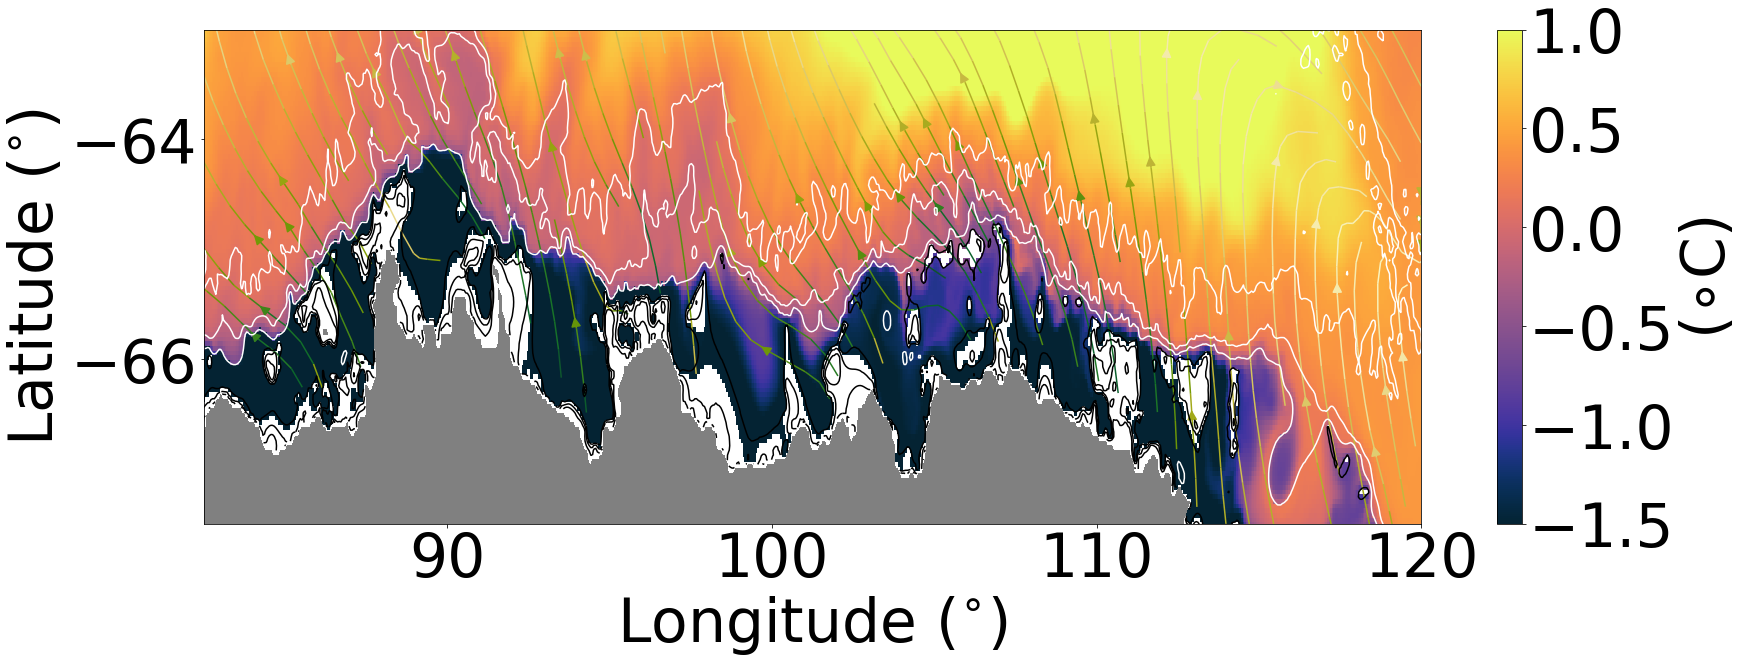

In [23]:
#Prepping variables to plot
fontsize=60

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(60, 20))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
                        temp_400m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1)
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1)
c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.speed)
#plt.title('2012 (March-May)',fontsize=fontsize)
#plt.title('mCDW in East Antarctica',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000,3000],colors='white',linewidth=.5)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[200,300,400],colors='k',linewidth=.5)
        #plot contours
#plt.contourf(ht.xt_ocean,ht.yt_ocean,ht)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^{\circ}$)',fontsize=fontsize)
plt.xlabel('Longitude ($^{\circ}$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-275, -200))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-280+360,-270+360,-260+360,-250+360,-240+360,-230+360,-220+360,-210+360,-200+360])

#fig.tight_layout()
#figdir = '/home/581/ns3783/Scripts/Figures/Current'
#filestr = figdir+'/mCDW_fig.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [24]:
np.nanmin(ws)

8.984122e-05

[Text(-280.0, 0, '80'),
 Text(-260.0, 0, '90'),
 Text(-240.0, 0, '100'),
 Text(-220.0, 0, '110'),
 Text(-200.0, 0, '120')]

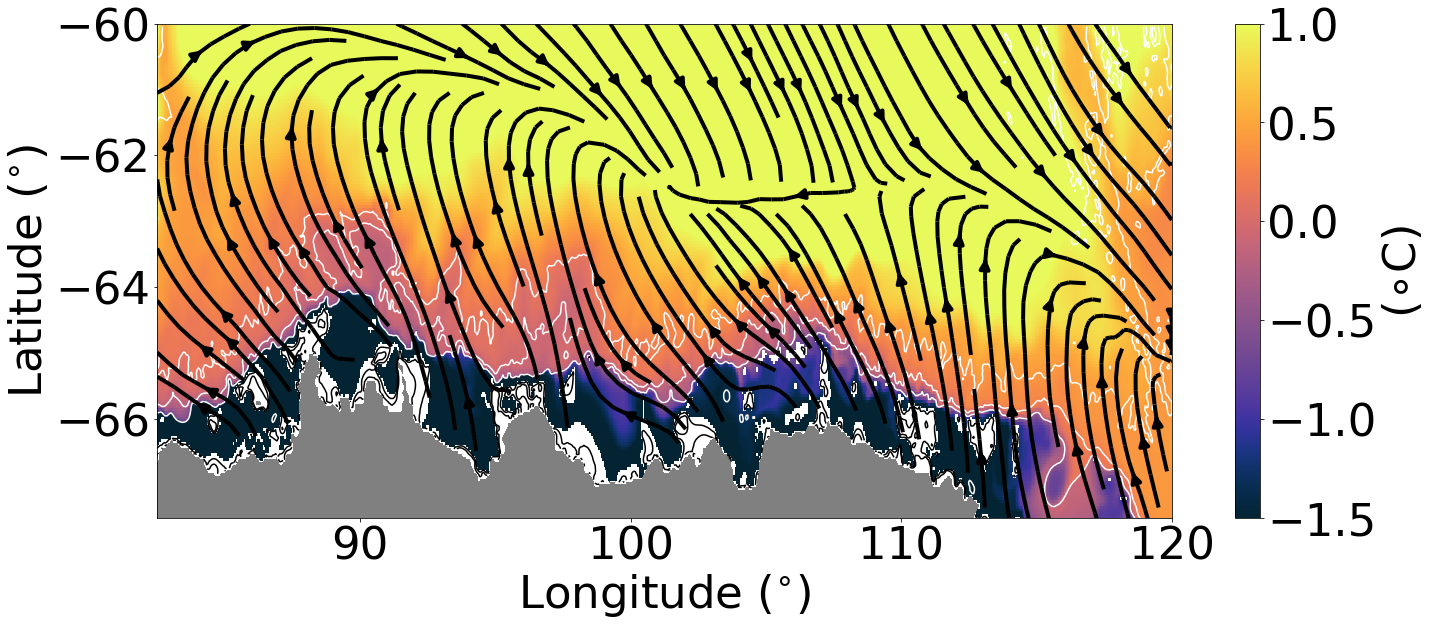

In [25]:
#Prepping variables to plot
fontsize=45

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(50, 20)) #(70,30) was the original
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
                        temp_400m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1)
#plt.title('2012 (March-May)',fontsize=fontsize)
#plt.title('mCDW in East Antarctica',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000,3000],colors='white',linewidth=.5)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[200,300],colors='k',linewidth=.5)
c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray, norm = mcolors.Normalize(vmin = 0, vmax = 8, clip = True), linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^{\circ}$)',fontsize=fontsize)
plt.xlabel('Longitude ($^{\circ}$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -60))
plt.xlim((-275, -200))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-280+360,-270+360,-260+360,-250+360,-240+360,-230+360,-220+360,-210+360,-200+360])


#cbar2 = fig.colorbar(c.lines, orientation = 'vertical')
#cbar2.set_ticks(np.arange(0, 0.5, 0.1))
#cbar2.set_label('Wind speed (m s$^{-1}$)',fontsize=fontsize,labelpad=8)
#cbar2.ax.tick_params(labelsize=fontsize)

#fig.tight_layout()
#figdir = '/home/581/ns3783/Scripts/Figures/Current'
#filestr = figdir+'/mCDW_fig_60_2.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

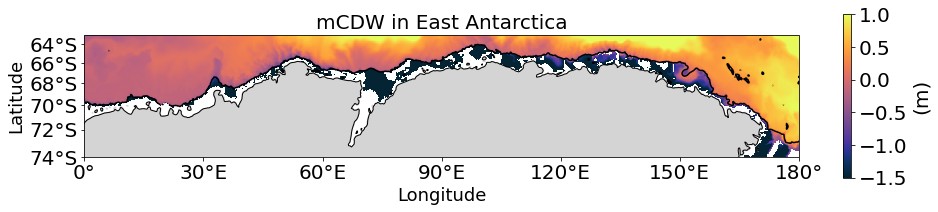

In [27]:
projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-63)
plt.figure(figsize=(16,30))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-63], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
                        temp_400m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
                        temp_1000m_off, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
# taking the winds out beccause the aspect ration is weird
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -72,-70, -68, -66, -64], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=20);
plt.title('mCDW in East Antarctica',fontsize=20)
ax.set_xlabel('Longitude',fontsize=18)
ax.set_ylabel('Latitude',fontsize=18)
cbar=plt.colorbar(pc,shrink=0.1,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'(m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)


fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/mCDW_cartopy.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

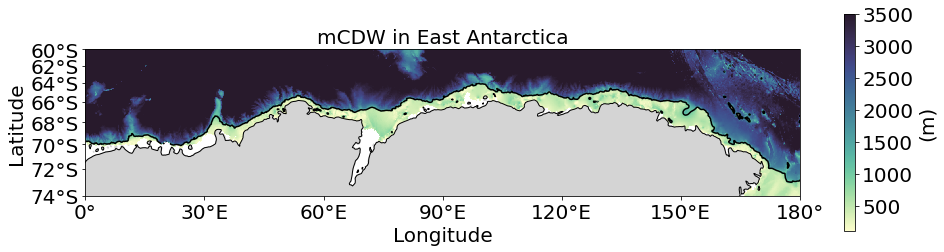

In [54]:
projection=ccrs.Mercator(central_longitude=90, min_latitude=-75.5,max_latitude=-60)
plt.figure(figsize=(16,40))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([0, 180, -74,-60], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour
pc = plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,
                       ht, cmap = cmocean.deep,vmin=100,vmax=3500, 
                       transform=ccrs.PlateCarree())
#pc = plt.pcolormesh(temp_400m_off.xt_ocean,temp_400m_off.yt_ocean,
#                        temp_400m_off, cmap = cmocean.thermal, 
#                        vmin=-1.5,vmax=1,transform=ccrs.PlateCarree())
#pc = plt.pcolormesh(temp_1000m_off.xt_ocean,temp_1000m_off.yt_ocean,
#                        temp_1000m_off, cmap = cmocean.thermal, 
#                        vmin=-1.5,vmax=1, transform=ccrs.PlateCarree())
#c = plt.streamplot(lon, y, up, vp, color = ws, density = 2, arrowsize = 2, cmap = cmocean.gray,transform=ccrs.PlateCarree())
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[0,1000],colors='k',linewidth=.5,transform=ccrs.PlateCarree())
#plt.colorbar(shrink=0.6).set_label('(m)', fontsize=16)
# set custom longitude and latitude values with correct formatting
ax.set_xticks([0, 30, 60, 90,120,150,180], crs=ccrs.PlateCarree())   
ax.set_yticks([-74, -72,-70, -68, -66, -64,-62,-60], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
# set longitude and latitude tick size
ax.tick_params(labelsize=20);
plt.title('mCDW in East Antarctica',fontsize=20)
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
cbar=plt.colorbar(pc,shrink=0.1,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'(m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)

fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/mCDW_cartopy_60.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')